# Chapter 2: Small worlds and large worlds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import mcx

from matplotlib import pylab as plt
%matplotlib inline

In [3]:
print(f"MCX v{mcx.__version__}")
print(f"JAX v{jax.__version__}")
print(f"Numpy v{np.__version__}")

MCX v0.0.1
JAX v0.1.77
Numpy v1.19.4


## Components of the model

In [4]:
from mcx.distributions import Binomial

The binomial distribution formula is built into mcx so you can compute the probability of 6 Ws in 9 tosses for every value of $p$:

In [5]:
np.exp(Binomial(0.5, 9).logpdf(6))

/home/remi/.virtualenvs/mcx/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


0.1640631

## 2.4.3 Grid approximation

### With a uniform prior

In [6]:
# R code 2.3. adapted
def grid_posterior(n_points):
    p_grid = np.linspace(0, 1, n_points)
    prior = np.ones(n_points)
    likelihood = np.exp(Binomial(p_grid, 9).logpdf(6))
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / np.sum(unstd_posterior)
    return p_grid, posterior

Text(0, 0.5, 'poterior probability')

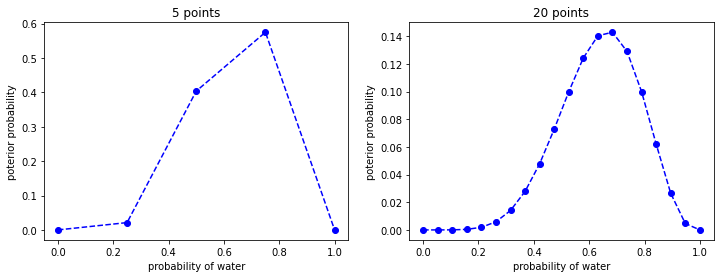

In [7]:
# R code 2.4
p_5, posterior_5 = grid_posterior(5)
p_20, posterior_20 = grid_posterior(20)

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
ax1.plot(p_5, posterior_5, '--bo')
ax1.set_title("5 points")
ax1.set_xlabel("probability of water")
ax1.set_ylabel("poterior probability")

ax2 = fig.add_subplot(122)
ax2.plot(p_20, posterior_20, '--bo')
ax2.set_title("20 points")
ax2.set_xlabel("probability of water")
ax2.set_ylabel("poterior probability")

### With different priors

The two plots below correspond to the R code 2.5.

In [8]:
def grid_posterior_half_prior(n_points):
    """Compute the values of the posterior at fixed points. 
    
    The prior value is equal to 0 when the probability of water is smaller than 0.5,
    and 1 otherwise.
    """
    p_grid = np.linspace(0, 1, n_points)
    prior = np.where(p_grid < 0.5, 0, 1)
    likelihood = np.exp(Binomial(p_grid, 9).logpdf(6))
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / np.sum(unstd_posterior)
    return p_grid, posterior

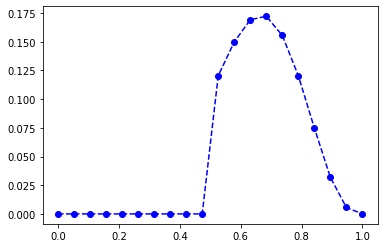

In [9]:
p_grid, posterior = grid_posterior_half_prior(20)
plt.plot(p_grid, posterior, '--bo')

In [10]:
def grid_posterior_exp_prior(n_points):
    """Compute the values of the posterior at fixed points. 
    
    The prior value is equal to $e^{-5 |p_{grid}-0.5|}$.
    """
    p_grid = np.linspace(0, 1, n_points)
    prior = np.exp(-5 * np.abs(p_grid-0.5))
    likelihood = np.exp(Binomial(p_grid, 9).logpdf(6))
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / np.sum(unstd_posterior)
    return p_grid, posterior

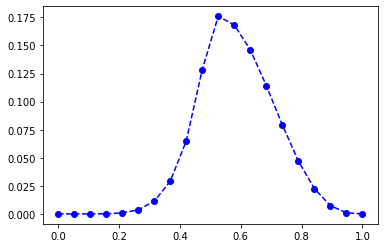

In [11]:
p_grid, posterior = grid_posterior_exp_prior(20)
plt.plot(p_grid, posterior, '--bo')

## 2.4.4 Quadratic appromixation

The grid approximation does not scale to a large number of dimensions. Instead we use a *quadratic approximation*, i.e. we assume that the posterior is a multivariate gaussian distribution. We first find the posterior mode and then estimate the curvature of the posterior near this peak.

In [12]:
# Code R 2.6 (cette cellule et la suivante)
import functools
from mcx.distributions import Binomial, Uniform

@mcx.model
def globe_tossing(L):
    p <~ Uniform(0, 1)
    W <~ Binomial(p, W+L)
    return W

# We condition the posterior distribution on the data
loglikelihood = functools.partial(globe_tossing.logpdf, W=6, L=3)

Since we conditioned on the values of $W$ and $L$ we now need to find an approximation for the posterior distribution of $p$. This would be easy to do using Variational Inference but since MCX does not support Variational inference we will have to find the approximation by hand.

To find the mean of the posterior (assumed to be gaussian) we look for the value of $p$ that maximizes the loglikelihood (MAP estimation). The standard deviation is given by the square root of the logilikelihood's hessian at the mean:

In [13]:
from scipy.optimize import minimize

mean = minimize(lambda x: -float(loglikelihood(x)), [.5], bounds=[(0,1)], method='Nelder-Mead').x[0]
std = np.sqrt(float(-1 /  jax.hessian(loglikelihood)(mean)))

/home/remi/.virtualenvs/mcx/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


The quantiles can be easily computed using `scipy.stats.norm` with the mean and std previously obtained. Since `globe_tossing` is a conjugate model we actually have an analytical expression of the posterior which we can now compare to the approximation.

In [17]:
from mcx.distributions import Beta
import scipy.stats as stats

W = 6
L = 3
water_proportions = np.linspace(0, 1, 100)[1:-1]

posterior = [np.exp(Beta(W+1, L+1).logpdf(p)) for p in water_proportions]
posterior_approx = [stats.norm(mean, std).pdf(p) for p in water_proportions]

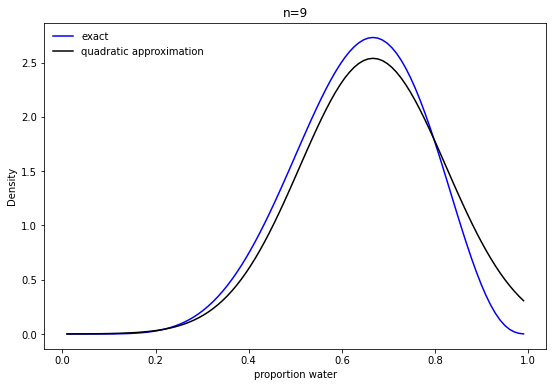

In [18]:
fig = plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)
ax.plot(water_proportions, posterior, 'b', label='exact')
ax.plot(water_proportions, posterior_approx, 'k', label='quadratic approximation')
ax.set_title("n=9")
ax.set_xlabel("proportion water")
ax.set_ylabel("Density")
plt.legend(frameon=False);

## 2.4.5 Markov Chain Monte Carlo

We reproduce here the code of the "Overthinking" Monte Carlo globe tossing" code example.

In [46]:
# R Code 2.8
from mcx.distributions import Binomial

W = 6
L = 3
n_samples = 10_000

p = [.5]
for i in range(n_samples):
    p_new = np.random.normal(p[i], 0.1)
    p_new = abs(p_new) if p_new < 0 else p_new
    p_new = 2 - p_new if p_new > 1 else p_new
    q0 = stats.binom.pmf(W, W+L, p[i])
    q1 = stats.binom.pmf(W, W+L, p_new)
    do_accept = np.random.rand()
    if q1/q0 > do_accept:
        p.append(p_new)
    else:
        p.append(p[i])

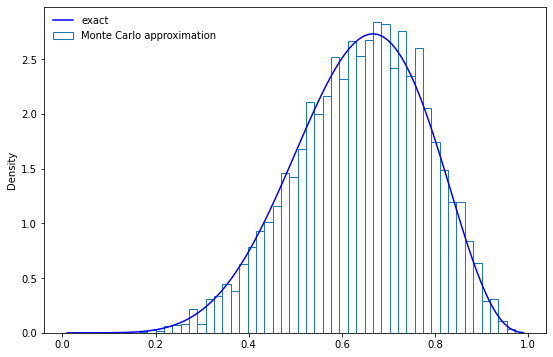

In [60]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)
sns.histplot(p, stat='density', fill=None, label="Monte Carlo approximation")
ax.plot(water_proportions, posterior, 'b', label='exact')
plt.legend(frameon=False);